In [31]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [10]:
jpy_usd = pd.read_csv('../temp_data/jpy_usd.csv')
eur_usd = pd.read_csv('../temp_data/eur_usd.csv')
jpy_eur = pd.read_csv('../temp_data/jpy_eur.csv')

jpy_usd['Date'] = pd.to_datetime(jpy_usd['Date'])
eur_usd['Date'] = pd.to_datetime(eur_usd['Date'])
jpy_eur['Date'] = pd.to_datetime(jpy_eur['Date'])

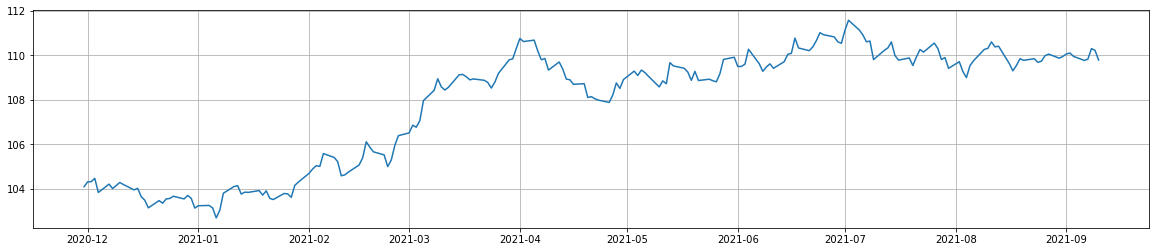

In [13]:
plt.figure(figsize=(20,4))
plt.plot(jpy_usd['Date'],jpy_usd['Close'])
plt.grid()
plt.show()

In [17]:
jpy_usd['close_pct_change_before1'] = jpy_usd['Close'].pct_change()

In [22]:
jpy_usd['up_or_down'] = (jpy_usd['close_pct_change_before1']>0).astype(int)

In [43]:
def ema(s, term=5):
    '''指数平滑移動平均の計算'''
    sma = s.rolling(term).mean()[:term]
    return pd.concat([sma, s[term:]]).ewm(span=term, adjust=False).mean()

def calc_macd(s,short_term=12,long_term=26, signal_term=9):
    """
    s: pd.Series、為替データ
    return: macd,macd_signal
    """
    short_term_ema = ema(s,short_term)
    long_term_ema = ema(s,long_term)
    macd = short_term_ema - long_term_ema
    macd_signal = ema(macd,signal_term)
    return macd,macd_signal

def out_cross_flag(macd,macd_signal):

    cross_list = []
    be_flag = 0
    af_flag = 0
    for i in range(len(macd)):

        #欠損値でないなら
        if ~np.isnan(macd[i]):
            #どちらが上かによるフラグ
            if macd[i] <= macd_signal[i]:
                af_flag = 0
            else:
                af_flag = 1

            #一つ前のフラグより大きい小さいがあればクロス
            if be_flag < af_flag:
                cross_list.append('gold')
            elif be_flag > af_flag:
                cross_list.append('dead')
            else:
                cross_list.append(0)
        else:
            cross_list.append(np.nan)

        #フラグ更新
        be_flag = af_flag
    return pd.Series(cross_list)

#MACDの計算
macd,macd_signal = calc_macd(jpy_usd['Close'],short_term=3,long_term=12,signal_term=6)
jpy_usd['macd_flag'] = out_cross_flag(macd,macd_signal)

In [44]:
jpy_usd

,Date,Open,High,Low,Close,Adj Close,Volume,close_pct_change_before1,up_or_down,macd_flag
0,2020-11-30,104.100998,104.384003,103.830002,104.082001,104.082001,0,NaN,0,NaN
1,2020-12-01,104.301003,104.572998,104.185997,104.299004,104.299004,0,0.002085,1,NaN
2,2020-12-02,104.289001,104.747002,104.224998,104.308998,104.308998,0,0.000096,1,NaN
3,2020-12-03,104.456001,104.532997,103.675003,104.458000,104.458000,0,0.001428,1,NaN
4,2020-12-04,103.823997,104.241997,103.737999,103.822998,103.822998,0,-0.006079,0,NaN
...,...,...,...,...,...,...,...,...,...,...
200,2021-09-06,109.778000,109.931000,109.749001,109.764000,109.764000,0,-0.001646,0,0
201,2021-09-07,109.819000,110.250999,109.686996,109.820000,109.820000,0,0.000510,1,0
202,2021-09-08,110.289001,110.440002,110.139999,110.295998,110.295998,0,0.004334,1,gold
203,2021-09-09,110.220001,110.267998,109.752998,110.218002,110.218002,0,-0.000707,0,0


In [60]:
#所持金（円）
possession = 1000000

In [61]:
pos_list = []
for i in range(len(jpy_usd)):
    val = jpy_usd.loc[i,'Close']
    pos_list.append(possession)
    flag = jpy_usd.loc[i,'macd_flag']
    if flag == 'gold':
        dol_posses = possession/val
    elif flag == 'dead':
        possession = dol_posses*val

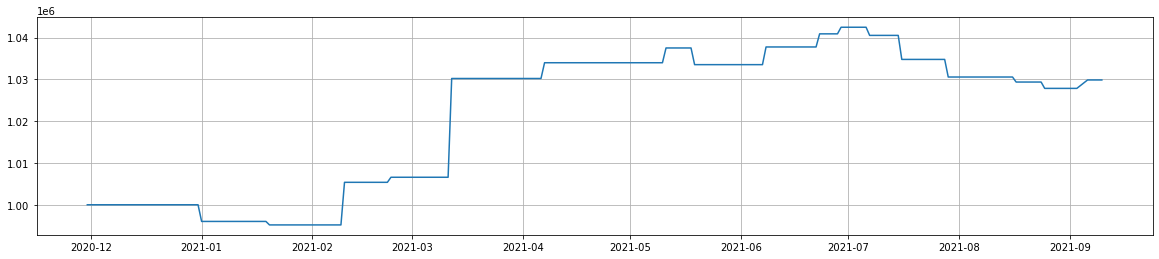

In [62]:
jpy_usd['pos'] = pos_list

plt.figure(figsize=(20,4))
plt.plot(jpy_usd['Date'],jpy_usd['pos'])
plt.grid()
plt.show()